In [1]:
import numpy as np
from sklearn.datasets        import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics         import accuracy_score
from sklearn.linear_model    import LogisticRegression
import umap
import torch
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append('..')
from dpa.dpa_fit import MDDPA
import matplotlib.pyplot as plt

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_all, y_all = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y_all = y_all.astype(int)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=0
)

In [3]:
rng = np.random.RandomState(0)
# — pick 50 samples of digit ‘0’
zeros_idx = np.where(y_train_full == 0)[0]
train_idx = list(rng.choice(zeros_idx, size=50, replace=False))
# — pick ~105 samples of each other digit 1–9
for cls in range(1, 10):
    cls_idx = np.where(y_train_full == cls)[0]
    train_idx += list(rng.choice(cls_idx, size=200, replace=False))
train_idx = np.array(train_idx)

X_train = X_train_full[train_idx] / 255.0   # normalize to [0,1]
y_train = y_train_full[train_idx]

In [4]:
X_train.shape, y_train.shape

((1850, 784), (1850,))

In [5]:
hold_idx = []
for cls in range(10):
    cls_idx = np.where(y_test_full == cls)[0]
    hold_idx += list(rng.choice(cls_idx, size=20, replace=False))
hold_idx = np.array(hold_idx)

X_hold = X_test_full[hold_idx] / 255.0
y_hold = y_test_full[hold_idx]

In [6]:
X_hold.shape, y_hold.shape

((200, 784), (200,))

In [71]:
clf0 =  KNeighborsClassifier(n_neighbors=200)#(random_state=0, max_depth=4)
clf0.fit(X_train, y_train)
print("Raw train acc:", accuracy_score(y_train, clf0.predict(X_train)))
print("Raw hold acc:",  accuracy_score(y_hold,  clf0.predict(X_hold)))

Raw train acc: 0.674054054054054
Raw hold acc: 0.575


In [72]:
print("hold acc on class = 0:",  accuracy_score(y_hold[y_hold==0],  clf0.predict(X_hold[y_hold==0])))

hold acc on class = 0: 0.0


In [9]:
umap_model = umap.UMAP(n_components=2, n_neighbors=15, random_state=42, metric='euclidean')
E_train = umap_model.fit_transform(X_train)
E_hold  = umap_model.transform(   X_hold)

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/var/folders/2q/4kcdg9gn3lbbjv6rtmgzglk00000gn/T/ipykernel_5922/2489284130.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


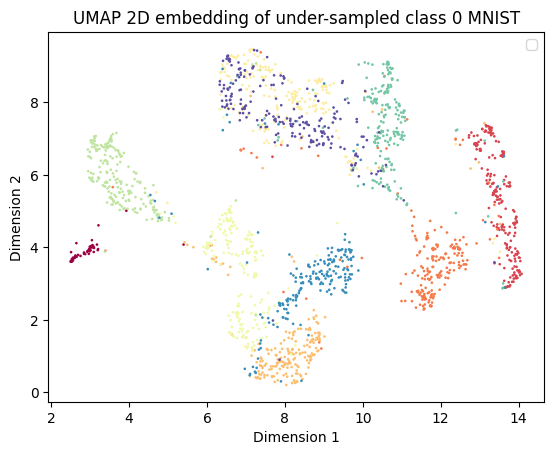

In [10]:
plt.scatter(E_train[:, 0], E_train[:, 1], c = y_train, cmap='Spectral', s= 0.8)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP 2D embedding of under-sampled class 0 MNIST')
plt.legend()
plt.savefig("../plots/embedding_umap.png", bbox_inches="tight")

In [27]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

dpa = MDDPA(data_dim=784, latent_dims=[5,4,3,2,1,0], num_layer=4, hidden_dim=500, coef_distill_latent=0.5, noise_dim=10, device=device)
dpa.train(torch.Tensor(X_train), torch.Tensor(E_train), batch_size=250, num_epochs=500)

Running on CPU.

Start training with 8 batches each of size 250.

[Epoch 1] 7.6678, 7.6534, 7.6573, 7.6643, 7.6647, 7.1757
 pred 	9.9046, 9.8970, 9.9018, 9.9028, 9.9019, 11.8193
 var 	4.4736, 4.4872, 4.4892, 4.4770, 4.4745, 9.2872

[Epoch 100] 3.7178, 3.7211, 3.7309, 3.7028, 3.7060, 5.0653
 pred 	7.4068, 7.4052, 7.3809, 7.4106, 7.3727, 9.9632
 var 	7.3779, 7.3682, 7.2999, 7.4155, 7.3333, 9.7957

[Epoch 200] 3.3958, 3.3890, 3.4035, 3.4141, 3.3994, 5.0644
 pred 	6.7949, 6.7735, 6.7985, 6.7861, 6.7953, 10.0297
 var 	6.7981, 6.7690, 6.7899, 6.7439, 6.7917, 9.9305

[Epoch 300] 3.2217, 3.2174, 3.2459, 3.2239, 3.2322, 5.0579
 pred 	6.4447, 6.4397, 6.4482, 6.4556, 6.4445, 10.0364
 var 	6.4461, 6.4447, 6.4047, 6.4634, 6.4247, 9.9570

[Epoch 400] 3.1230, 3.0953, 3.1137, 3.1192, 3.1145, 5.0714
 pred 	6.2346, 6.2603, 6.2407, 6.2538, 6.2536, 10.0562
 var 	6.2232, 6.3300, 6.2539, 6.2692, 6.2783, 9.9696

[Epoch 500] 3.0357, 3.0253, 3.0127, 3.0329, 3.0367, 5.0271
 pred 	6.1028, 6.0972, 6.1043, 6.0983,

In [28]:
D_train = dpa.encode(torch.Tensor(X_train).to(device), k=2, mean=True)

/var/folders/2q/4kcdg9gn3lbbjv6rtmgzglk00000gn/T/ipykernel_5922/3875044771.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


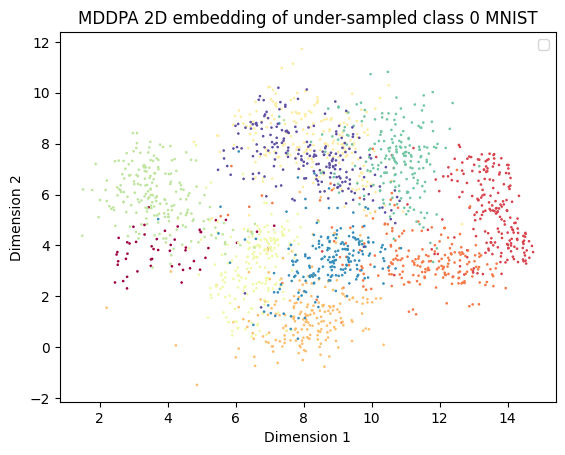

In [29]:
plt.scatter(D_train[:, 0].cpu().numpy(), D_train[:, 1].cpu().numpy(), c = y_train, cmap='Spectral', s= 0.8)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('MDDPA 2D embedding of under-sampled class 0 MNIST')
plt.legend()
plt.savefig("../plots/embedding_mddpa.png", bbox_inches="tight")

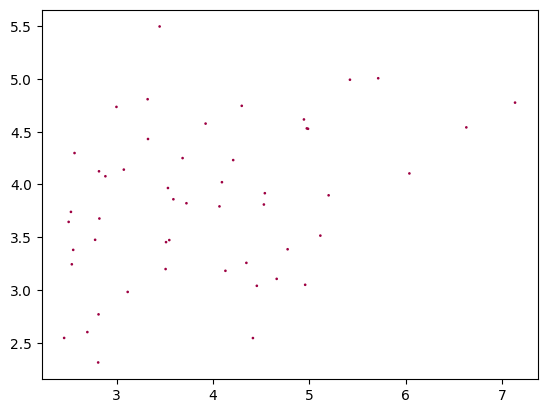

In [30]:
D_train_0 = D_train[y_train == 0]

plt.scatter(D_train_0[:, 0].cpu().numpy(), D_train_0[:, 1].cpu().numpy(), c = y_train[y_train == 0], cmap='Spectral', s= 0.8)

In [31]:
X0 = X_train[y_train == 0]

syn_X = dpa.reconstruct(torch.from_numpy(X0).float().to(device), gen_sample_size=3).cpu().numpy()#dpa.decode(torch.from_numpy(syn_z).float().to(device)).cpu().numpy()

In [32]:
syn_X = np.vstack((syn_X[:, :, 0], syn_X[:, :, 1], syn_X[:, :, 2]))

In [73]:
# augment training set
X_aug = np.vstack([X_train, syn_X])
y_aug = np.hstack([y_train, np.zeros(len(syn_X), dtype=int)])

# 7) Retrain classifier on augmented pixel‐space
clf1 =  KNeighborsClassifier(n_neighbors=200) #(random_state=0, max_depth=4)
clf1.fit(X_aug, y_aug)
print("Aug train acc:", accuracy_score(y_aug, clf1.predict(X_aug)))
print("Aug hold acc:",  accuracy_score(y_hold, clf1.predict(X_hold)))


Aug train acc: 0.7105
Aug hold acc: 0.645


In [75]:
print("hold acc on class = 0:",  accuracy_score(y_hold[y_hold==0],  clf1.predict(X_hold[y_hold==0])))

hold acc on class = 0: 0.75


In [76]:

# 8) Compare in embedding space
clf_emb =  KNeighborsClassifier(n_neighbors=200)
clf_emb.fit(E_train, y_train)
print("Embed train acc:", accuracy_score(y_train, clf_emb.predict(E_train)))
print("Embed hold acc:", accuracy_score(y_hold, clf_emb.predict(E_hold)))

Embed train acc: 0.7702702702702703
Embed hold acc: 0.69


In [77]:
print("hold acc on class = 0:",  accuracy_score(y_hold[y_hold==0],  clf_emb.predict(E_hold[y_hold==0])))

hold acc on class = 0: 0.0


In [78]:
D_train = dpa.encode(torch.Tensor(X_train).to(device), k=2, mean=True).cpu().numpy()
D_hold= dpa.encode(torch.Tensor(X_hold).to(device), k=2, mean=True).cpu().numpy()

# Train clf_dpa on the embedded data
clf_dpa =  KNeighborsClassifier(n_neighbors=200) #(random_state=0, max_depth=4)
clf_dpa.fit(D_train, y_train)

# Evaluate the classifier
print("Embed train acc:", accuracy_score(y_train, clf_dpa.predict(D_train)))
print("Embed hold acc:", accuracy_score(y_hold, clf_dpa.predict(D_hold)))

Embed train acc: 0.7248648648648649
Embed hold acc: 0.595


In [79]:
print("hold acc on class = 0:",  accuracy_score(y_hold[y_hold==0],  clf_dpa.predict(D_hold[y_hold==0])))

hold acc on class = 0: 0.0


In [80]:
syn_D = dpa.encode(torch.from_numpy(X0).float().to(device), k=2, gen_sample_size=3, mean=False).cpu().numpy()

syn_D = np.vstack((syn_D[:, :, 0], syn_D[:, :, 1], syn_D[:, :, 2]))

E_mush_train = np.vstack([E_train, syn_D])
y_mush_train = np.hstack([y_train, np.zeros(150, dtype=int)])

# Train a classifier on the combined dataset
clf_mush =  KNeighborsClassifier(n_neighbors=200) #(random_state=0, max_depth=4)
clf_mush.fit(E_mush_train, y_mush_train)

# Evaluate the classifier on E_hold
print("Mush train acc:", accuracy_score(y_mush_train, clf_mush.predict(E_mush_train)))
print("Mush hold acc:", accuracy_score(y_hold, clf_mush.predict(E_hold)))


Mush train acc: 0.795
Mush hold acc: 0.77


In [81]:
print("hold acc on class = 0:",  accuracy_score(y_hold[y_hold==0],  clf_mush.predict(E_hold[y_hold==0])))

hold acc on class = 0: 0.8


In [82]:


E_mix_train = np.vstack([E_train, umap_model.transform(syn_X)])
y_mix_train = np.hstack([y_train, np.zeros(150, dtype=int)])

# Train a classifier on the combined dataset
clf_mix =  KNeighborsClassifier(n_neighbors=200) #(100, random_state=0, max_depth=4)
clf_mix.fit(E_mix_train, y_mix_train)

# Evaluate the classifier on E_hold
print("Mush train acc:", accuracy_score(y_mix_train, clf_mix.predict(E_mix_train)))
print("Mush hold acc:", accuracy_score(y_hold, clf_mix.predict(E_hold)))


/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mush train acc: 0.8045
Mush hold acc: 0.77


In [83]:
print("hold acc on class = 0:",  accuracy_score(y_hold[y_hold==0],  clf_mix.predict(E_hold[y_hold==0])))

hold acc on class = 0: 0.8


In [2]:
import scanpy as sc

ModuleNotFoundError: No module named 'scanpy'